# **MARVEL HEROES CLASSIFIER USING CNNs**

Firstly run this cell to load your google drive inside Colab, so that you have access to the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)


Mounted at /content/gdrive/


All required libraries are imported in this cell.

Write code to import TensorFlow where comment is marked.

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [ ]:
#finding out the total number of images and extensions of images
images_paths = glob("/content/gdrive/MyDrive/01marvel/training data/*/*.*")
print('Total number of images are {}'.format(len(images_paths)))
hashset = set()
for item in images_paths:
  item = item.split(".")
  hashset.add(item[-1])
print(hashset)
print("Sample image paths")
for item in images_paths[610:620]:
  print(item)

Total number of images are 1388
{'jpg', 'jpeg', 'png'}
Sample image paths
/content/gdrive/MyDrive/01marvel/training data/iron man/images137.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images146.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images145.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images124.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images116.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images91.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images128.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images95.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images149.jpg
/content/gdrive/MyDrive/01marvel/training data/iron man/images117.jpg


In the below cell, provide address of any image to view as a sample

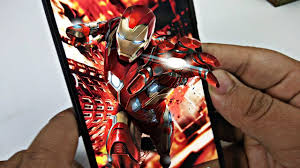

In [ ]:
#viewing one image 
# provide address inside sample_image variable
sample_image = "/content/gdrive/MyDrive/01marvel/training data/iron man/images157.jpg"
PIL.Image.open(sample_image)

In [ ]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir = r'/content/gdrive/MyDrive/01marvel/training data/'
good_exts=['jpg', 'png', 'jpeg', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print('no improper image files were found')

processing class directory  thor
processing class directory  iron man
processing class directory  hulk
no improper image files were found


In [ ]:
#if bad images are found then delete them
for img in bad_file_list:
  os.remove(img)

**SOME PARAMETERS WHICH SHOULD BE SET BEFORE TRAINING THE MODEL**

INSTRUCTIONS:
1.   Uncomment the code and fill integer values according to below instructions.
2.   Usually batch size is in the powers of 2, batch size of 32 would be ideal here.
3.  As dataset consists of images of different shapes we need to reshape them to a uniform shape, make the images of shape(512 x 512).




In [ ]:
#setting up basic parameters for loading the dataset
batch_size = 32
img_height = 512
img_width = 512

In [ ]:
data_dir = "/content/gdrive/MyDrive/01marvel/training data"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1388 files belonging to 3 classes.
Using 1111 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1388 files belonging to 3 classes.
Using 277 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['hulk', 'iron man', 'thor']


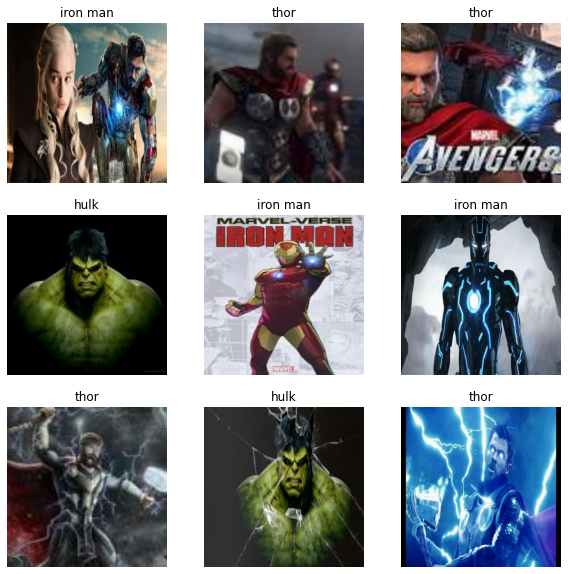

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def normalize(image_tensor,label):
  image_tensor = image_tensor/255.0
  return image_tensor,label

In [ ]:
train_ds = train_ds.map(normalize)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.map(normalize)
val_ds = val_ds.prefetch(AUTOTUNE)

In [ ]:
num_classes = 3

def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)
  ])
  model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])
  return model

In [ ]:
model = create_model()

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/01marvel/saved model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 )

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=12,
  callbacks=[cp_callback]
)

Epoch 1/12
35/35 [==============================] - ETA: 0s - loss: 1.1776 - accuracy: 0.4014
Epoch 1: saving model to /content/gdrive/MyDrive/01marvel/saved model/cp.ckpt
35/35 [==============================] - 35s 594ms/step - loss: 1.1776 - accuracy: 0.4014 - val_loss: 0.9583 - val_accuracy: 0.4801
Epoch 2/12
35/35 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.5761
Epoch 2: saving model to /content/gdrive/MyDrive/01marvel/saved model/cp.ckpt
35/35 [==============================] - 14s 402ms/step - loss: 0.8852 - accuracy: 0.5761 - val_loss: 0.6632 - val_accuracy: 0.6859
Epoch 3/12
35/35 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.7165
Epoch 3: saving model to /content/gdrive/MyDrive/01marvel/saved model/cp.ckpt
35/35 [==============================] - 15s 441ms/step - loss: 0.6226 - accuracy: 0.7165 - val_loss: 0.5566 - val_accuracy: 0.7653
Epoch 4/12
35/35 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0

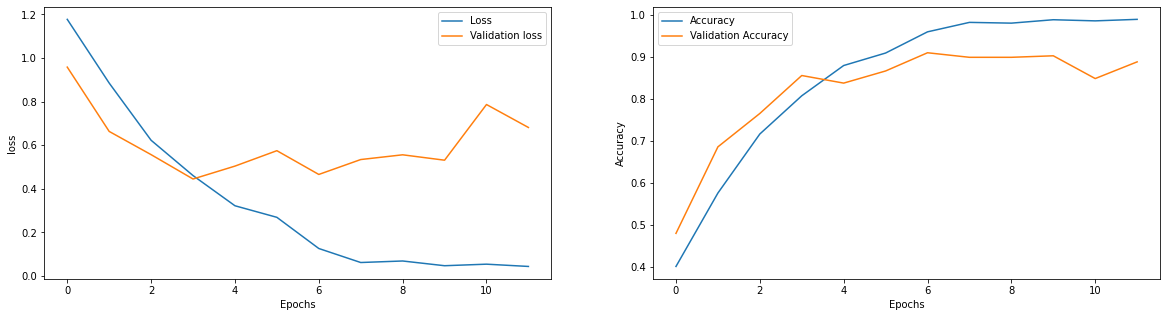

In [ ]:
#graph
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()


plt.subplot(122)
plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

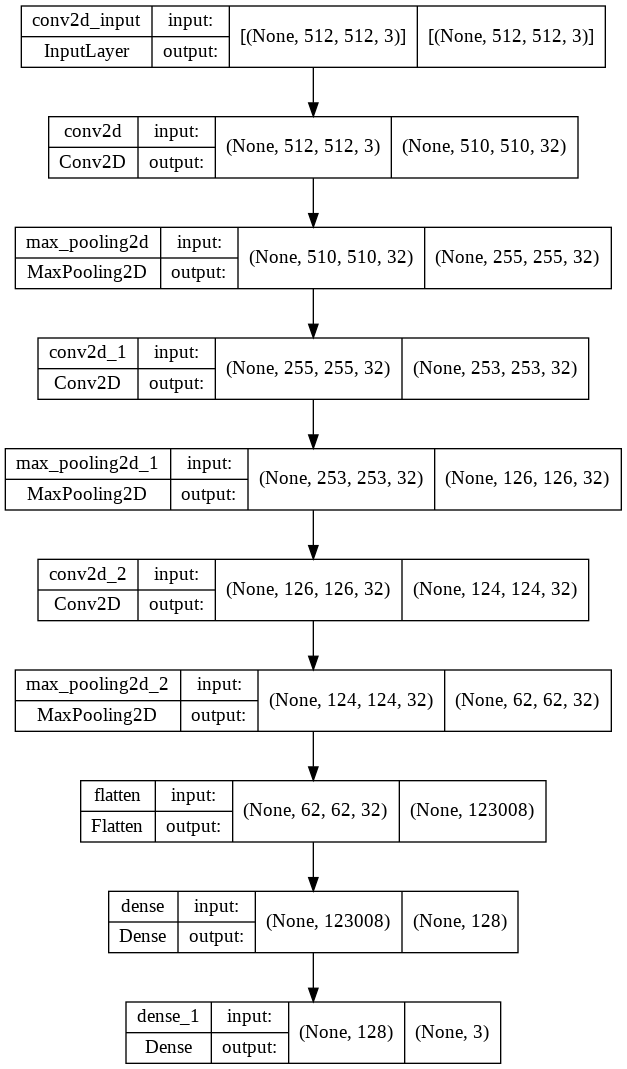

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='/content/model.png', show_shapes=True
)

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/gdrive/MyDrive/01marvel/testing data",
  image_size=(img_height, img_width),
  batch_size = 1) 



Found 38 files belonging to 3 classes.


In [ ]:
print(test_ds.class_names)

['hulk', 'iron man', 'thor']


In [ ]:
test_ds = test_ds.map(normalize)

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/01marvel/saved model/cp.ckpt"
model = create_model()
model.load_weights(checkpoint_path)

In [ ]:
predictions = (model.predict(test_ds))

In [ ]:
map = {0:"hulk",1:"iron man",2:"thor"}
answer = []
for item in predictions:
  answer.append(map[list(item).index(max(item))])
print(answer)


['iron man', 'iron man', 'hulk', 'thor', 'iron man', 'hulk', 'hulk', 'iron man', 'thor', 'hulk', 'thor', 'hulk', 'hulk', 'iron man', 'thor', 'iron man', 'iron man', 'hulk', 'iron man', 'iron man', 'iron man', 'iron man', 'iron man', 'thor', 'iron man', 'iron man', 'thor', 'thor', 'thor', 'iron man', 'thor', 'iron man', 'hulk', 'thor', 'thor', 'thor', 'iron man', 'hulk']


In [ ]:
loss,accuracy = model.evaluate(test_ds)
print(f"Accuracy : {accuracy}")
print(f"Loss : {loss}")

38/38 [==============================] - 1s 19ms/step - loss: 0.0100 - accuracy: 1.0000
Accuracy : 1.0
Loss : 0.010019945912063122


In [ ]:
def get_pred(img_path):
  img = image.load_img(img_path, target_size=(512, 512,3))
  img_array = image.img_to_array(img)
  plt.imshow(img_array.astype("uint8"))
  img_batch = np.expand_dims(img_array, axis=0)
  prediction = model.predict(img_batch)
  label = map[list(prediction[0]).index(max(prediction[0]))]
  return label


thor


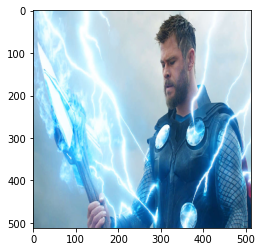

In [ ]:
print(get_pred('/content/gdrive/MyDrive/01marvel/training data/thor/1NgHp8.jpg'))

In [ ]:
model.save('/content/gdrive/MyDrive/01marvel/tmp/my_model.h5')

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 4.4 MB/s 
     |████████████████████████████████| 462 kB 49.3 MB/s 


In [ ]:
!tensorflowjs_converter --input_format=keras /content/gdrive/MyDrive/01marvel/tmp/my_model.h5 /content/gdrive/MyDrive/01marvel/tmp/tfjs.h5